# Timeseries Forecasting (RNN)

## Load Libraries and Data

In [1]:
import logging
import pathlib
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Restrict tensorflow output to errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Plot formatting
%matplotlib inline
sns.set()
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Working with Timeseries Data in Tensorflow

In [8]:
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # Targets for prediction are 3 steps in future
    sequence_length=3,
    batch_size=5
)
list(my_dataset)

[(<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3],
         [2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 4, 5], dtype=int32)>)]

In [9]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f'{element}', end=' ')
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [10]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f'{window_tensor}')

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


### Data Source

Load [ridership data](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97) from the Chicago Transit Authority.

In [11]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

path = pathlib.Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [12]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


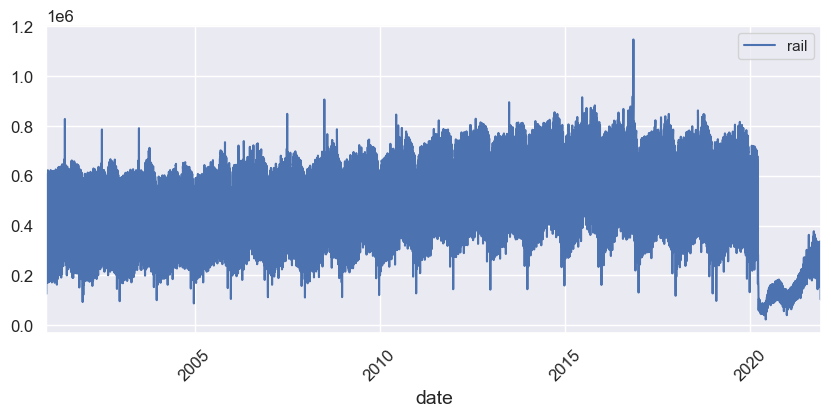

In [13]:
# Plot the full dataset
fig, ax = plt.subplots(figsize=(10, 4))
df.plot(y='rail', ax=ax)
plt.xticks(rotation=45)
plt.show()

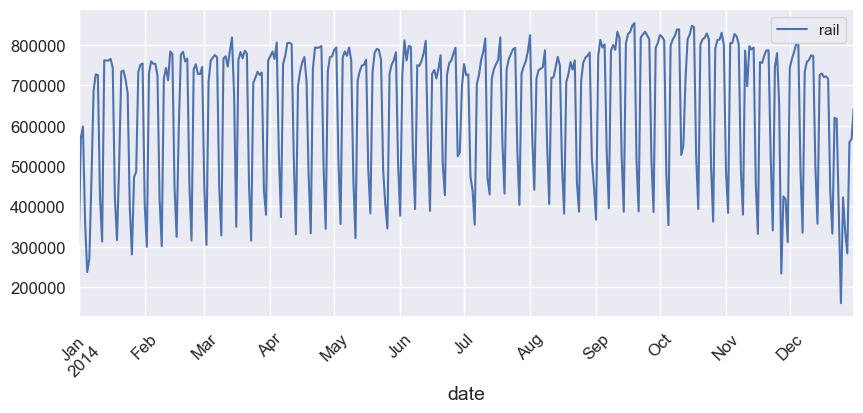

In [16]:
# Plot 2016 and 2017
fig, ax = plt.subplots(figsize=(10, 4))
df['2014-01':'2014-12'].plot(y='rail', ax=ax)
plt.xticks(rotation=45)
plt.show()

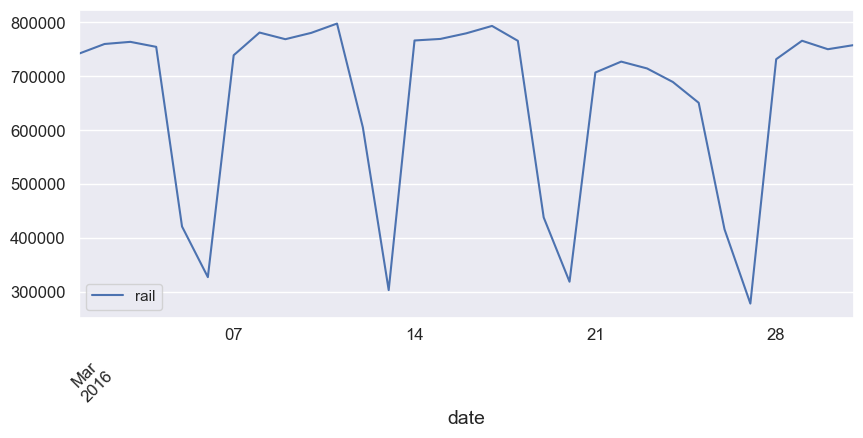

In [17]:
# Plot January 2016
fig, ax = plt.subplots(figsize=(10, 4))
df['2016-03-01':'2016-03-31'].plot(y='rail', ax=ax)
plt.xticks(rotation=45)
plt.show()

### Setup Data for Training

In [23]:
rail_train = df['rail']['2016-01':'2018-12'] / 1e6
rail_valid = df['rail']['2019-01':'2019-05'] / 1e6
rail_test = df['rail']['2019-06':] / 1e6

In [24]:
# Predict rail riders tomorrow using sequence of rail riders
# over past 8 weeks (56 days)

seq_length = 56  # 8 weeks
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True  # Helps backprop by presenting instances in random order
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

## A First RNN

In [26]:
tf.keras.backend.clear_session()

# Note: default activation is tanh
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [28]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10,
                                                     restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(train_ds, validation_data=valid_ds,
                    epochs=50, callbacks=[early_stopping_cb])

Epoch 1/50
33/33 [==============================] - 1s 8ms/step - loss: 0.4839 - mae: 0.8589 - val_loss: 0.0316 - val_mae: 0.1818
Epoch 2/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0623 - mae: 0.3016 - val_loss: 0.0763 - val_mae: 0.3491
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0624 - mae: 0.3044 - val_loss: 0.0590 - val_mae: 0.2959
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0362 - mae: 0.2010 - val_loss: 0.0219 - val_mae: 0.1245
Epoch 5/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0173 - mae: 0.1556 - val_loss: 0.0158 - val_mae: 0.1447
Epoch 6/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0162 - mae: 0.1586 - val_loss: 0.0158 - val_mae: 0.1366
Epoch 7/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0158 - mae: 0.1542 - val_loss: 0.0154 - val_mae: 0.1369
Epoch 8/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0155 - mae: 0.15

In [30]:
valid_loss, valid_mae = model.evaluate(valid_ds)
print(valid_mae * 1e6)

3/3 [==============================] - 0s 3ms/step - loss: 0.0219 - mae: 0.1245
124526.19522809982


In [31]:
df['rail'].mean()

540347.5877732688

In [32]:
(valid_mae * 1e6) / df['rail'].mean()

0.23045572525133826

In [18]:
df['rail'].describe()

count    7.639000e+03
mean     5.403476e+05
std      2.053951e+05
min      2.354400e+04
25%      3.546900e+05
50%      6.085350e+05
75%      7.091390e+05
max      1.146516e+06
Name: rail, dtype: float64

### Exercise

How would you characterize the performance of the first simple RNN model?

## Refining the RNN

Two issues with initial RNN:

1. Very simple (one neuron, 3 parameters)
2. Activation function is tanh, which doesn't hit all possible target values

In the following model, we increase the count of neurons in the recurrent layer, and we add a dense layer to scale the recurrent layer's tanh output.

In [33]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10,
                                                     restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(train_ds, validation_data=valid_ds,
                    epochs=50, callbacks=[early_stopping_cb])

Epoch 1/50
33/33 [==============================] - 1s 12ms/step - loss: 0.0168 - mae: 0.1467 - val_loss: 0.0073 - val_mae: 0.0977
Epoch 2/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0064 - mae: 0.0851 - val_loss: 0.0030 - val_mae: 0.0577
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0647 - val_loss: 0.0030 - val_mae: 0.0536
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0040 - mae: 0.0594 - val_loss: 0.0029 - val_mae: 0.0520
Epoch 5/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0039 - mae: 0.0583 - val_loss: 0.0047 - val_mae: 0.0739
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0040 - mae: 0.0601 - val_loss: 0.0027 - val_mae: 0.0479
Epoch 7/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0037 - mae: 0.0561 - val_loss: 0.0026 - val_mae: 0.0457
Epoch 8/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0036 - mae: 0.0

In [35]:
valid_loss, valid_mae = model.evaluate(valid_ds)
print(valid_mae * 1e6)

3/3 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0326
32627.489417791367


In [36]:
(valid_mae * 1e6) / df['rail'].mean()

0.06038240968604443

## A Multivariate RNN

In [37]:
# Setup data for training
df_mulvar = df[['bus', 'rail']] / 1e6

# Let model observe the day type for which it forecasts
df_mulvar['next_day_type'] = df['day_type'].shift(-1)  
df_mulvar = pd.get_dummies(df_mulvar)

mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [38]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train['rail'][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid['rail'][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [39]:
tf.keras.backend.clear_session()

# Note increased number of features
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10,
                                                     restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds,
                    epochs=50, callbacks=[early_stopping_cb])

Epoch 1/50
33/33 [==============================] - 1s 9ms/step - loss: 0.0682 - mae: 0.2581 - val_loss: 0.0084 - val_mae: 0.1232
Epoch 2/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0040 - mae: 0.0709 - val_loss: 8.1523e-04 - val_mae: 0.0308
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0019 - mae: 0.0428 - val_loss: 0.0015 - val_mae: 0.0460
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0017 - mae: 0.0413 - val_loss: 6.5045e-04 - val_mae: 0.0252
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0015 - mae: 0.0382 - val_loss: 9.7380e-04 - val_mae: 0.0343
Epoch 6/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0013 - mae: 0.0338 - val_loss: 0.0011 - val_mae: 0.0369
Epoch 7/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0013 - mae: 0.0358 - val_loss: 0.0025 - val_mae: 0.0629
Epoch 8/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0014

In [41]:
valid_loss, valid_mae = model.evaluate(valid_mulvar_ds)
print(valid_mae * 1e6)

3/3 [==============================] - 0s 3ms/step - loss: 6.5045e-04 - mae: 0.0252
25240.587070584297


In [42]:
(valid_mae * 1e6) / df['rail'].mean()

0.04671176043294434